In [517]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

## Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

### Table 1: A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

In [300]:
th = pd.read_csv('/Users/ajeustis/Downloads/relax_challenge/takehome_user_engagement.csv')
th['time_stamp'] = pd.to_datetime(th['time_stamp'])
# th = th.set_index(['time_stamp'])
th.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [250]:
th.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [251]:
th.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [252]:
th.isnull().sum()

user_id    0
visited    0
dtype: int64

In [302]:
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

th['visits_7_days'] = th.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')
th.head()

,time_stamp,user_id,visited,visits_7_days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [305]:
adopted_users = th[th['visits_7_days'] >= 3]
adopted_users.shape

(160522, 4)

In [253]:
# Get counts for logins on a weekly basis
# th_df = th.groupby('user_id').rolling('7d').count()

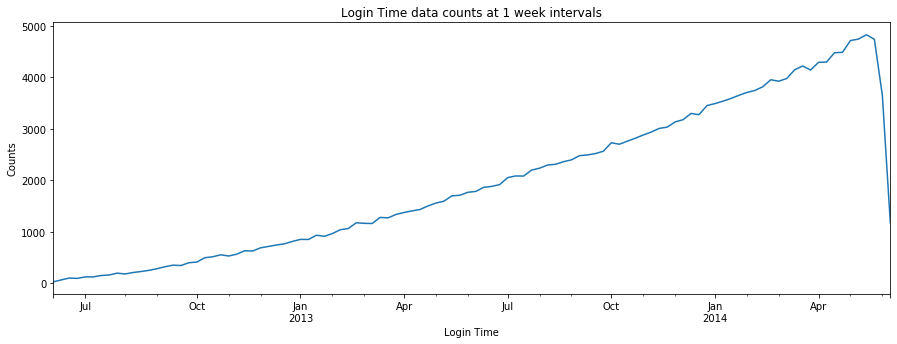

In [254]:
# Plot
plt.figure(figsize=(15,5))
th.sort_index().resample('1W').size().plot()
plt.title('Login Time data counts at 1 week intervals')
plt.xlabel('Login Time')
plt.ylabel('Counts')
plt.show()

In [306]:
# Function to assign 1 for adopted user and 0 for not an adopted user based on the visited variable
def f(row):
    if row['visits_7_days'] >= 3:
        adopted_users = 1
    else:
        adopted_users = 0
    return adopted_users

In [308]:
# Apply the function
th['adopted_users'] = th.apply(f, axis=1)

In [312]:
th.head()

,time_stamp,user_id,visited,visits_7_days,adopted_users
0,2014-04-22 03:53:30,1,1,1.0,0
1,2013-11-15 03:45:04,2,1,1.0,0
2,2013-11-29 03:45:04,2,1,1.0,0
3,2013-12-09 03:45:04,2,1,1.0,0
4,2013-12-25 03:45:04,2,1,1.0,0


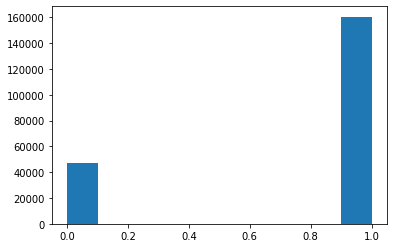

In [313]:
plt.hist(th['adopted_users'])
plt.show()

### Table 2: A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table contains: 

##### -  name: the user's name
##### -  object_id: the user's id
##### -  email: email address
##### -  creation_source: how their account was created. This takes on one of 5 values:
> ##### -  PERSONAL_PROJECTS: invited to join another user's personal workspace
> ##### -  GUEST_INVITE: invited to an organization as a guest (limited permissions)
> ##### -  ORG_INVITE: invited to an organization (as a full member)
> ##### -  SIGNUP: signed up via the website
> ##### -  SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
##### -  creation_time: when they created their account
##### -  last_session_creation_time: unix timestamp of last login
##### -  opted_in_to_mailing_list: whether they have opted into receiving marketing emails
##### -  enabled_for_marketing_drip: whether they are on the regular marketing email drip
##### -  org_id: the organization (group of users) they belong to
##### -  invited_by_user_id: which user invited them to join (if applicable).

In [314]:
th_users = pd.read_csv('/Users/ajeustis/Downloads/relax_challenge/takehome_users.csv',  encoding='latin1')
th_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [315]:
# Convert to datetime
th_users['last_session_creation_time'] = pd.to_datetime(th_users['last_session_creation_time'], unit='s')
th_users['creation_time'] = pd.to_datetime(th_users['last_session_creation_time'])
th_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-22 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-22 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [316]:
th_users.shape
th_users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [317]:
# Count NAs
th_users.isnull().sum()

object_id                        0
creation_time                 3177
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [318]:
# Replace NAs with 0
th_users_clean = th_users.fillna(0)
th_users_clean.shape

(12000, 10)

In [338]:
th.shape

(207917, 5)

In [456]:
# Rename object id to user id
th_users_clean.rename(columns = {'object_id' : 'user_id'}, inplace = True )

In [515]:
th.head(1)

,time_stamp,user_id,visited,visits_7_days,adopted_users
0,2014-04-22 03:53:30,1,1,1.0,0


In [516]:
th_users_clean.head(1)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0


### Merging tables

In [513]:
# Join the two tables on user id
full_df = th_users_clean.merge(th, how ='inner',  left_on='user_id', right_on = 'user_id')
full_df.shape

(207917, 14)

In [426]:
full_df.head(2)

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2013-11-15 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [427]:
# Convert to datetime objects
full_df['last_session_creation_time'] = pd.to_datetime(full_df['last_session_creation_time'])
full_df['creation_time'] = pd.to_datetime(full_df['last_session_creation_time'])
full_df.head(1)

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0


In [428]:
full_df.dtypes

time_stamp                    datetime64[ns]
user_id                                int64
visited                                int64
visits_7_days                        float64
adopted_users                          int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

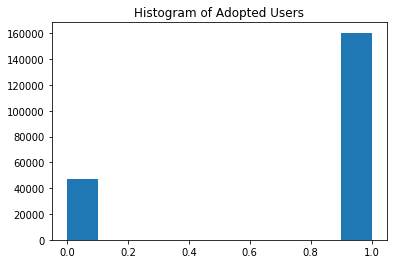

In [429]:
# Histogram of adopted users
plt.hist(full_df['adopted_users'])
plt.title('Histogram of Adopted Users')
plt.show()

In [430]:
# Counts 
full_df['creation_source'].value_counts()

ORG_INVITE            70091
GUEST_INVITE          46796
SIGNUP                37545
SIGNUP_GOOGLE_AUTH    34263
PERSONAL_PROJECTS     19222
Name: creation_source, dtype: int64

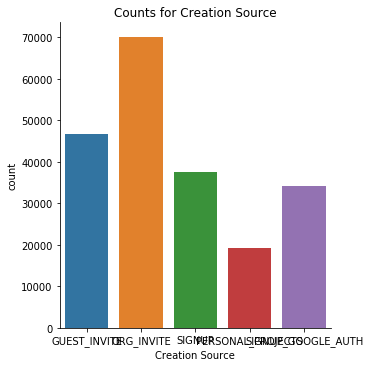

In [431]:
title = 'Counts for Creation Source'
sns.catplot(x='creation_source', kind="count", data=full_df);
plt.title(title)
plt.xlabel('Creation Source')
plt.show()

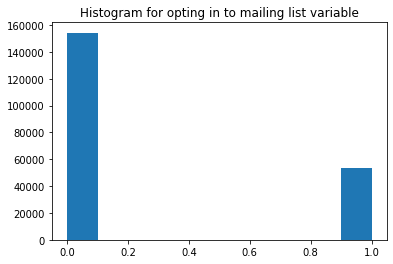

In [432]:
plt.hist(full_df['opted_in_to_mailing_list'])
plt.title('Histogram for opting in to mailing list variable')
plt.show()

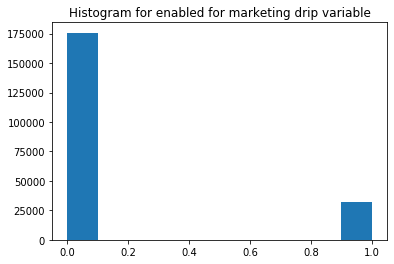

In [433]:
plt.hist(full_df['enabled_for_marketing_drip'])
plt.title('Histogram for enabled for marketing drip variable')
plt.show()

In [470]:
# Make invited_by_user_id variable categorical: 1 if invited, 0 if not. 
# Function to assign 1 for adopted user and 0 for not an adopted user based on the visited variable
def f(row):
    if row['invited_by_user_id'] > 0:
        invited = 1
    else:
        invited = 0
    return invited

In [471]:
# Apply the function
full_df['invited'] = full_df.apply(f, axis=1)

In [472]:
full_df.head()

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1
1,2013-11-15 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,2013-11-29 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
3,2013-12-09 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
4,2013-12-25 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1


In [473]:
# How can we extract features from datetime objects?

# For creation time perhaps year will be indicative since the range spans across about 2 years.
print(min(full_df['creation_time']))
print(max(full_df['creation_time']))

2012-05-31 08:20:06
2014-06-06 14:58:50


In [474]:
full_df['creation_year'] = full_df['creation_time'].dt.year
full_df.head(2)

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,creation_year
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,2014
1,2013-11-15 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2014


In [475]:
# Extract email source as potential variable
full_df['email_type'] = full_df['email'].str.split("@").str.get(1)
full_df.head()

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,creation_year,email_type
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,2014,yahoo.com
1,2013-11-15 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2014,gustr.com
2,2013-11-29 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2014,gustr.com
3,2013-12-09 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2014,gustr.com
4,2013-12-25 03:45:04,2,1,1.0,0,2014-03-31 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,2014,gustr.com


In [476]:
# Convert to categorical
full_df['email_type'] = pd.Categorical(full_df['email_type'])
full_df['email_type'].cat.categories

Index(['abdnf.com', 'adpql.com', 'aerbd.com', 'aethf.com', 'afzjt.com',
       'agfei.com', 'aiouj.com', 'aipbl.com', 'ajrkw.com', 'akwfl.com',
       ...
       'zjwjb.com', 'zkbxm.com', 'zkbzv.com', 'zkcdj.com', 'zkcep.com',
       'zkdih.com', 'zpbkw.com', 'zpcop.com', 'zsrgb.com', 'zssin.com'],
      dtype='object', length=812)

In [477]:
full_df['email_type'].value_counts().head(10)

# create list of categories
email_host_rank = full_df['email_type'].value_counts().index.tolist()

# create list of top 6
email_host_top_six = email_host_rank[:6]

# create list to replace with 'other'
email_host_replace = email_host_rank[6:]

In [478]:
# Create an other category for those where the value counts are below expected amount

# add new category
full_df['email_type'] = full_df['email_type'].cat.add_categories(['other'])

# replace the rest of the categories with 'other'
full_df['email_type'] = full_df['email_type'].replace(email_host_replace, 'other')

# remove unused categories
full_df['email_type'] = full_df['email_type'].cat.remove_unused_categories()

print(full_df['email_type'].value_counts())

gmail.com         71310
yahoo.com         31411
hotmail.com       25434
jourrapide.com    23274
other             20476
gustr.com         19509
cuvox.de          16503
Name: email_type, dtype: int64


In [479]:
full_df.describe()
# What needs to be converted to categorical data
# invited enabled_for_marketing_drip opted_in_to_mailing_list invited

,user_id,visited,visits_7_days,adopted_users,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,creation_year
count,207917.000000,207917.0,207917.000000,207917.000000,207917.000000,207917.000000,207917.000000,207917.000000,207917.000000,207917.000000
mean,5913.314197,1.0,4.381393,0.772048,0.258137,0.154533,164.315895,3357.439502,0.562181,2013.929770
std,3394.941674,0.0,2.042666,0.419512,0.437611,0.361460,121.165846,3834.871624,0.496120,0.298957
min,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000
25%,3087.000000,1.0,3.000000,1.000000,0.000000,0.000000,60.000000,0.000000,0.000000,2014.000000
50%,5682.000000,1.0,4.000000,1.000000,0.000000,0.000000,145.000000,1585.000000,1.000000,2014.000000
75%,8944.000000,1.0,6.000000,1.000000,1.000000,0.000000,260.000000,6442.000000,1.000000,2014.000000
max,12000.000000,1.0,7.000000,1.000000,1.000000,1.000000,416.000000,11999.000000,1.000000,2014.000000


In [486]:
# Convert to categorical or datetime
full_df['invited'] = pd.Categorical(full_df['invited'])
full_df['enabled_for_marketing_drip'] = pd.Categorical(full_df['enabled_for_marketing_drip'])
full_df['opted_in_to_mailing_list'] = pd.Categorical(full_df['opted_in_to_mailing_list'])
full_df['creation_source'] = pd.Categorical(full_df['creation_source'])
full_df['creation_year'] = pd.Categorical(full_df['creation_year'])

In [487]:
full_df.dtypes

time_stamp                    datetime64[ns]
user_id                                int64
visited                                int64
visits_7_days                        float64
adopted_users                          int64
creation_time                         object
name                                  object
email                                 object
creation_source                     category
last_session_creation_time            object
opted_in_to_mailing_list            category
enabled_for_marketing_drip          category
org_id                                 int64
invited_by_user_id                   float64
invited                             category
creation_year                       category
email_type                          category
dtype: object

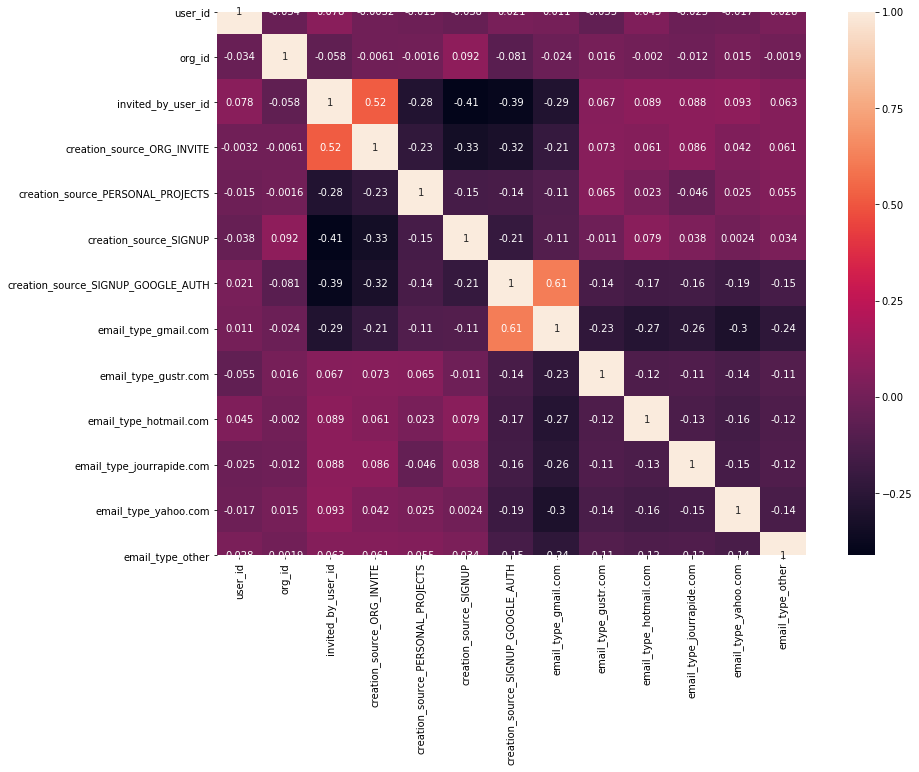

In [503]:
# Correlation Matrix
# Compute the correlation matrix
corrmat = X.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat, annot = True, fmt='.2g', square = True)
plt.show()

In [ ]:
# Determine variable importance in prediction of adopted users using random forest

In [490]:
full_df.head(1)

,time_stamp,user_id,visited,visits_7_days,adopted_users,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,creation_year,email_type
0,2014-04-22 03:53:30,1,1,1.0,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,2014,yahoo.com


In [498]:
# Create model
Y = full_df['adopted_users']
predictors = full_df.drop(columns = ['adopted_users', 'visits_7_days', 'visited', 'time_stamp', 
                            'creation_time', 'last_session_creation_time','name', 'email'])
predictors = pd.get_dummies(predictors ,columns= ['creation_source', 'email_type'], drop_first = True)
X = predictors
X

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited,creation_year,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_type_gmail.com,email_type_gustr.com,email_type_hotmail.com,email_type_jourrapide.com,email_type_yahoo.com,email_type_other
0,1,1,0,11,10803.0,1,2014,0,0,0,0,0,0,0,0,1,0
1,2,0,0,1,316.0,1,2014,1,0,0,0,0,1,0,0,0,0
2,2,0,0,1,316.0,1,2014,1,0,0,0,0,1,0,0,0,0
3,2,0,0,1,316.0,1,2014,1,0,0,0,0,1,0,0,0,0
4,2,0,0,1,316.0,1,2014,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207912,11996,0,0,89,8263.0,1,2013,1,0,0,0,0,1,0,0,0,0
207913,11997,0,0,200,0.0,0,2013,0,0,0,1,1,0,0,0,0,0
207914,11998,1,1,83,8074.0,1,2014,0,0,0,0,0,0,0,0,0,0
207915,11999,0,0,6,0.0,0,2012,0,1,0,0,0,0,0,0,0,1


In [499]:
# Run Random Forest Classifier
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, Y)

for name, importance in zip(X.columns, rnd_clf.feature_importances_):
     print(name, "=", importance)

user_id = 0.23716946810378642
opted_in_to_mailing_list = 0.018511006126140143
enabled_for_marketing_drip = 0.01497316947904958
org_id = 0.2172102342672976
invited_by_user_id = 0.10959211443697488
invited = 0.0055369065048486025
creation_year = 0.31986962371413863
creation_source_ORG_INVITE = 0.013956083516228146
creation_source_PERSONAL_PROJECTS = 0.004859716959559442
creation_source_SIGNUP = 0.006796079183116385
creation_source_SIGNUP_GOOGLE_AUTH = 0.003015110875703831
email_type_gmail.com = 0.008858246768132622
email_type_gustr.com = 0.008655767574260927
email_type_hotmail.com = 0.008093902642702716
email_type_jourrapide.com = 0.007949921887664699
email_type_yahoo.com = 0.007883072158219775
email_type_other = 0.007069575802175577


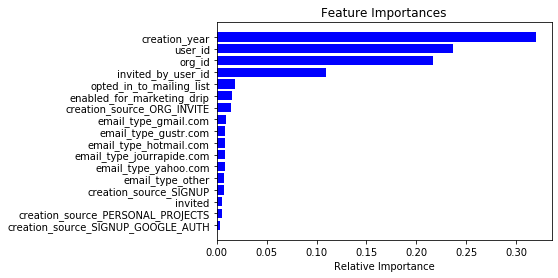

In [500]:
# Show feature importance
features = X.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Creation year, user ID, organization ID and invited by user id are very important indicators in whether or not a user becomes adopted. 

In [519]:
# Perform Grid search to tune parameters
parameters = {'n_estimators':[500, 1000], 'max_depth':[5,10]}
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
clf = GridSearchCV(rfc, parameters, cv = 5)
clf.fit(X, Y)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [520]:
# Best model happens to be the one we ran
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [532]:
# Has the highest test score
print(clf.cv_results_['mean_test_score'])
print(clf.cv_results_['std_test_score'])

[0.57845733 0.57845733 0.57471543 0.57424408]
[0.28425831 0.28425831 0.2812595  0.28090101]
